# Reinforcement Learning Chess
Reinforcement Learning Chess is a series of notebooks where I implement Reinforcement Learning algorithms to develop a chess AI. I start of with simpler versions (environments) that can be tackled with simple methods and gradually expand on those concepts untill I have a full-flegded chess AI.  

[Notebook 1: Policy Iteration  ](https://www.kaggle.com/arjanso/reinforcement-learning-chess-1-policy-iteration)  
[Notebook 2: Model-free learning  ](http://https://www.kaggle.com/arjanso/reinforcement-learning-chess-2-model-free-methods)  
[Notebook 3: Q-networks ](https://www.kaggle.com/arjanso/reinforcement-learning-chess-3-q-networks)  

# Notebook 4: Policy Gradients

**Environment:** Just like in notebook 3, I use a simplified version of chess named capture chess. In this environment the agent (playing white) is rewarded for capturing pieces (not for checkmate). After running this notebook, you end up with an agent that can capture pieces against a random oponnent as demonstrated in the gif below.  
**Policy Gradients:** In this notebook I introduce a different approach to reinforcement learning called policy gradients. The intuition behind policy gradients is that we want to increase the probability of actions with a high reward, and reduce the probability of actions with a low reward. This is different from the approach the previous notebooks, where focus on estimating the value of a state-action and then behaving (epsilon-) greedily w.r.t. the estimated value. The former case, which is applied here, is a policy-based method, whereas the latter case are value-based methods.
![](https://images.chesscomfiles.com/uploads/game-gifs/90px/green/neo/0/cc/0/0/anJXR21DNU9mTzJNT1hZSVg0M05kTj9WTjE4MTRYMVNYNlZ4NlpTWmd4N1l4TTkya0EyQm52WXdwd0JnaGdaUWNxR3lxSSFUSTB5cTBxUVpic1o4ZW04N2dlVEpzSjc2SnM2WnNIWjc,.gif)

**Import and install**

In [1]:
%load_ext autoreload
%autoreload 2
!pip install python-chess  # Python-Chess is the Python Chess Package that handles the chess environment
!pip install --upgrade git+https://github.com/arjangroen/RLC.git  # RLC is the Reinforcement Learning package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os
import inspect

     |████████████████████████████████| 133kB 2.8MB/s 
  Cloning https://github.com/arjangroen/RLC.git to /tmp/pip-req-build-gjmuskz4
  Running command git clone -q https://github.com/arjangroen/RLC.git /tmp/pip-req-build-gjmuskz4
  Created wheel for RLC: filename=RLC-0.1-cp36-none-any.whl size=13333 sha256=c9cecc5da1b23b58c5f869cba5be75568081bd1ac161893ea14a2ef47c78c026
  Stored in directory: /tmp/pip-ephem-wheel-cache-x3ywma_4/wheels/04/68/a5/cb835cd3d76a49de696a942739c71a56bfe66d0d8ea7b4b446
Successfully built RLC


In [2]:
import chess
from chess.pgn import Game
board = chess.Board()
import RLC
from RLC.capture_chess.environment import Board
from RLC.capture_chess.learn import Reinforce, ActorCritic
from RLC.capture_chess.agent import Agent, policy_gradient_loss
board = Board()
agent = Agent(network='conv_pg',lr=0.3)

R = Reinforce(agent,board)

Using TensorFlow backend.


**Theory**
- In policy gradient algorithms, we directly update the policy in the directly to optimize the expected rewards. This is different from value function approximation where we try to estimate the value of an action in a state.
- Policy Gradient is known to work well in continuous action spaces and large discrete action spaces (like chess). 
- The Policy Gradient algorithm demonstrated here is called REINFORCE
- The Keras implementation is designed like a supervised learning algorithm with a customized loss function (3).
   - We train a neural network to predict which action was taken under its own policy.
   - The loss is multiplied by  the future reward (G). This modification results in a loss identical to the policy gradient. 

**Implementation**

The loss function is modified so that the gradient is proportional to the rewards gained. The implementation is described here:
https://stackoverflow.com/questions/45961428/make-a-custom-loss-function-in-keras


In [3]:
print(inspect.getsource(policy_gradient_loss))

def policy_gradient_loss(Returns):
    def modified_crossentropy(action,action_probs):
        cost = (K.categorical_crossentropy(action,action_probs,from_logits=False,axis=1) * Returns)
        return cost
    return modified_crossentropy



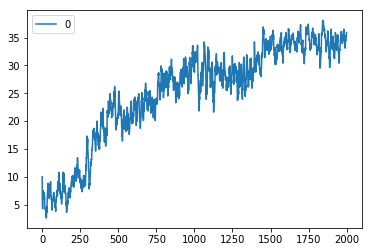

In [4]:
pgn = R.learn(iters=2000)

In [5]:
with open("final_game.pgn","w") as log:
    log.write(str(pgn))
    

### Actor Critic
The actor critic model is a combination of a policy-based approach such as REINFORCE and a value based approach such as Q learning (notebook 3). The central idea is to swap this Monte Carlo sample of Rewards by an estimate of the action value (Q). This Q value is approximated with a Q learning agent (notebook 3). 
The motivation for this is that Monte Carlo samples have very high variance. Using our Q network reduces this variance and gives a better value approximation than a single Monte Carlo sample. Additionally, we don't have to wait untill the end of the episode to evaluate an action. We always have our Q-network that can evaluate a state-action.

For this notebook, this does not give a noticable improvement in performance. The reason is that we do not have high variance to begin with because of our large discount factor and our simple neural network. The reason for this implementation is purely educational. 

In [6]:
board = Board()

critic = Agent(network='conv',lr=0.1)
critic.fix_model()
actor = Agent(network='conv_pg',lr=0.3)

R = ActorCritic(actor, critic,board)

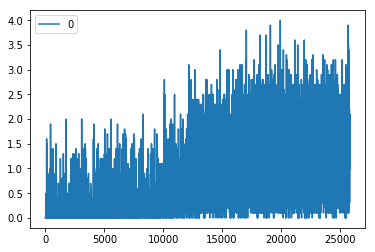

In [7]:
pgn = R.learn(iters=1000)

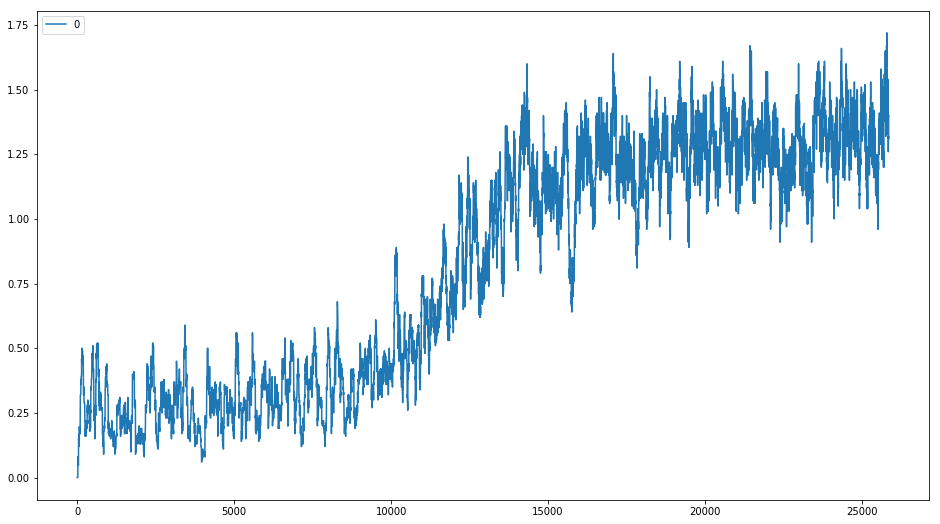

In [8]:
reward_smooth = pd.DataFrame(R.reward_trace)
reward_smooth.rolling(window=100,min_periods=0).mean().plot(figsize=(16,9))

# References
#### 1. Reinforcement Learning: An Introduction
> Richard S. Sutton and Andrew G. Barto
1st Edition
MIT Press, march 1998

#### 2. RL Course by David Silver: Lecture playlist
> https://www.youtube.com/watch?v=2pWv7GOvuf0&list=PLqYmG7hTraZDM-OYHWgPebj2MfCFzFObQ

#### 3, Notes on Policy Gradients in autodiff frameworks
>  https://aleksispi.github.io/assets/pg_autodiff.pdf 
